In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
46059,NaN,NaN,International,2020-09-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46060,NaN,NaN,International,2020-09-24,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46061,NaN,NaN,International,2020-09-25,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


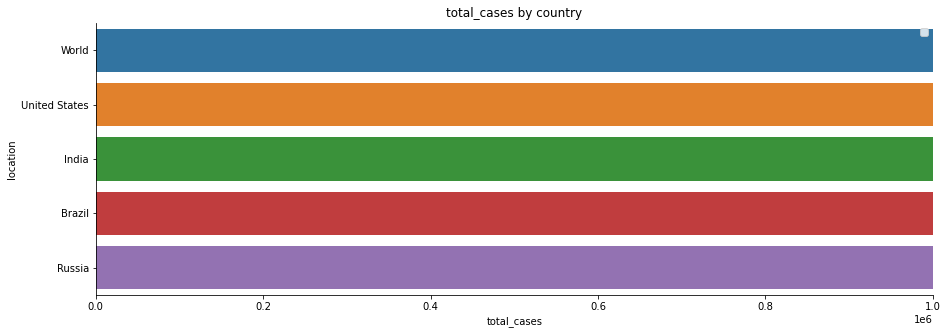

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


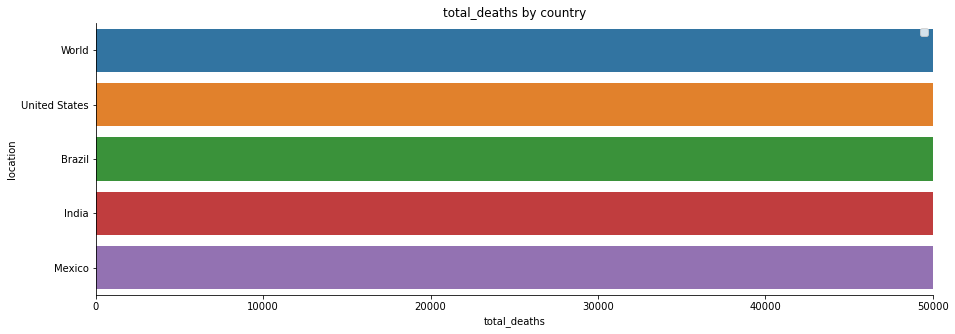

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


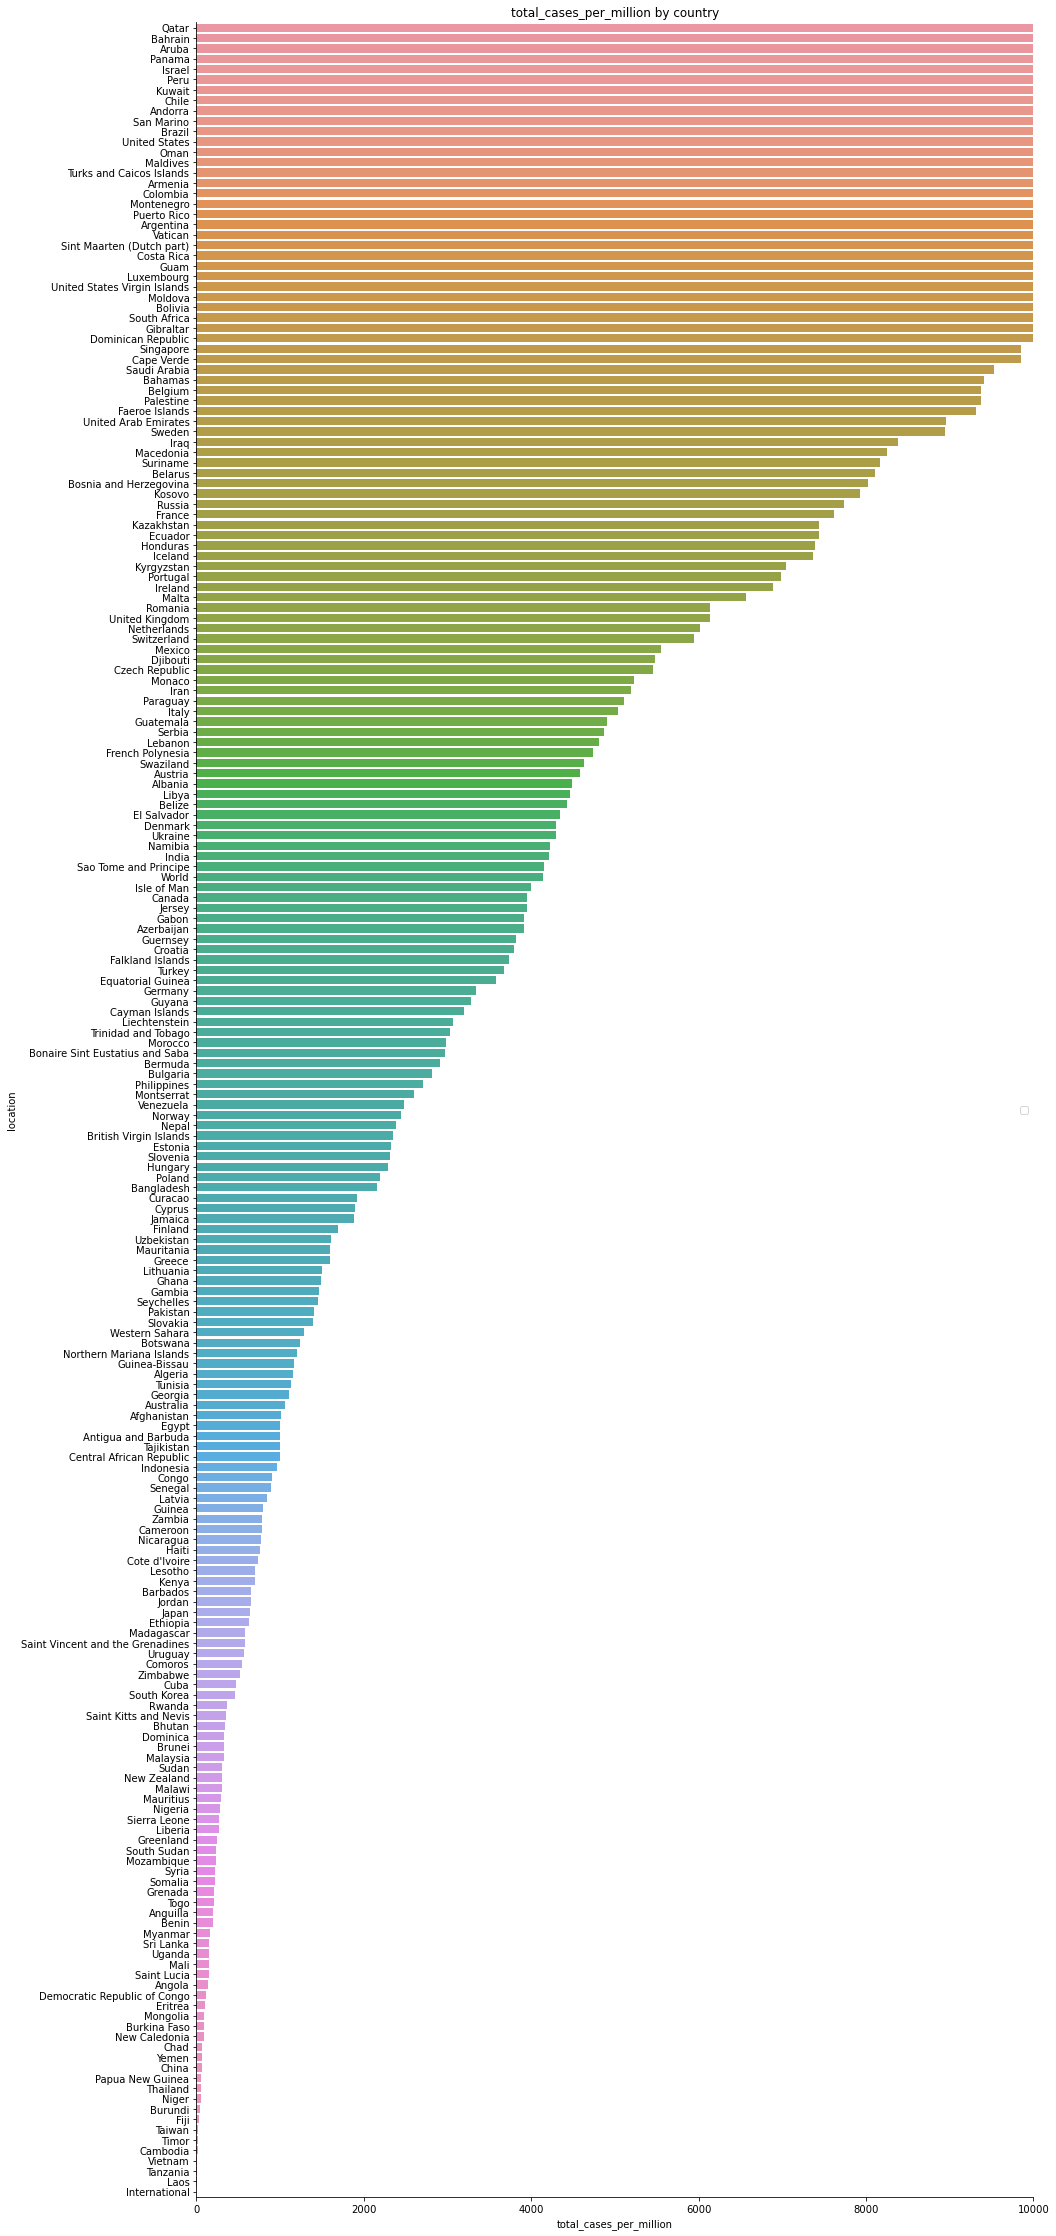

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


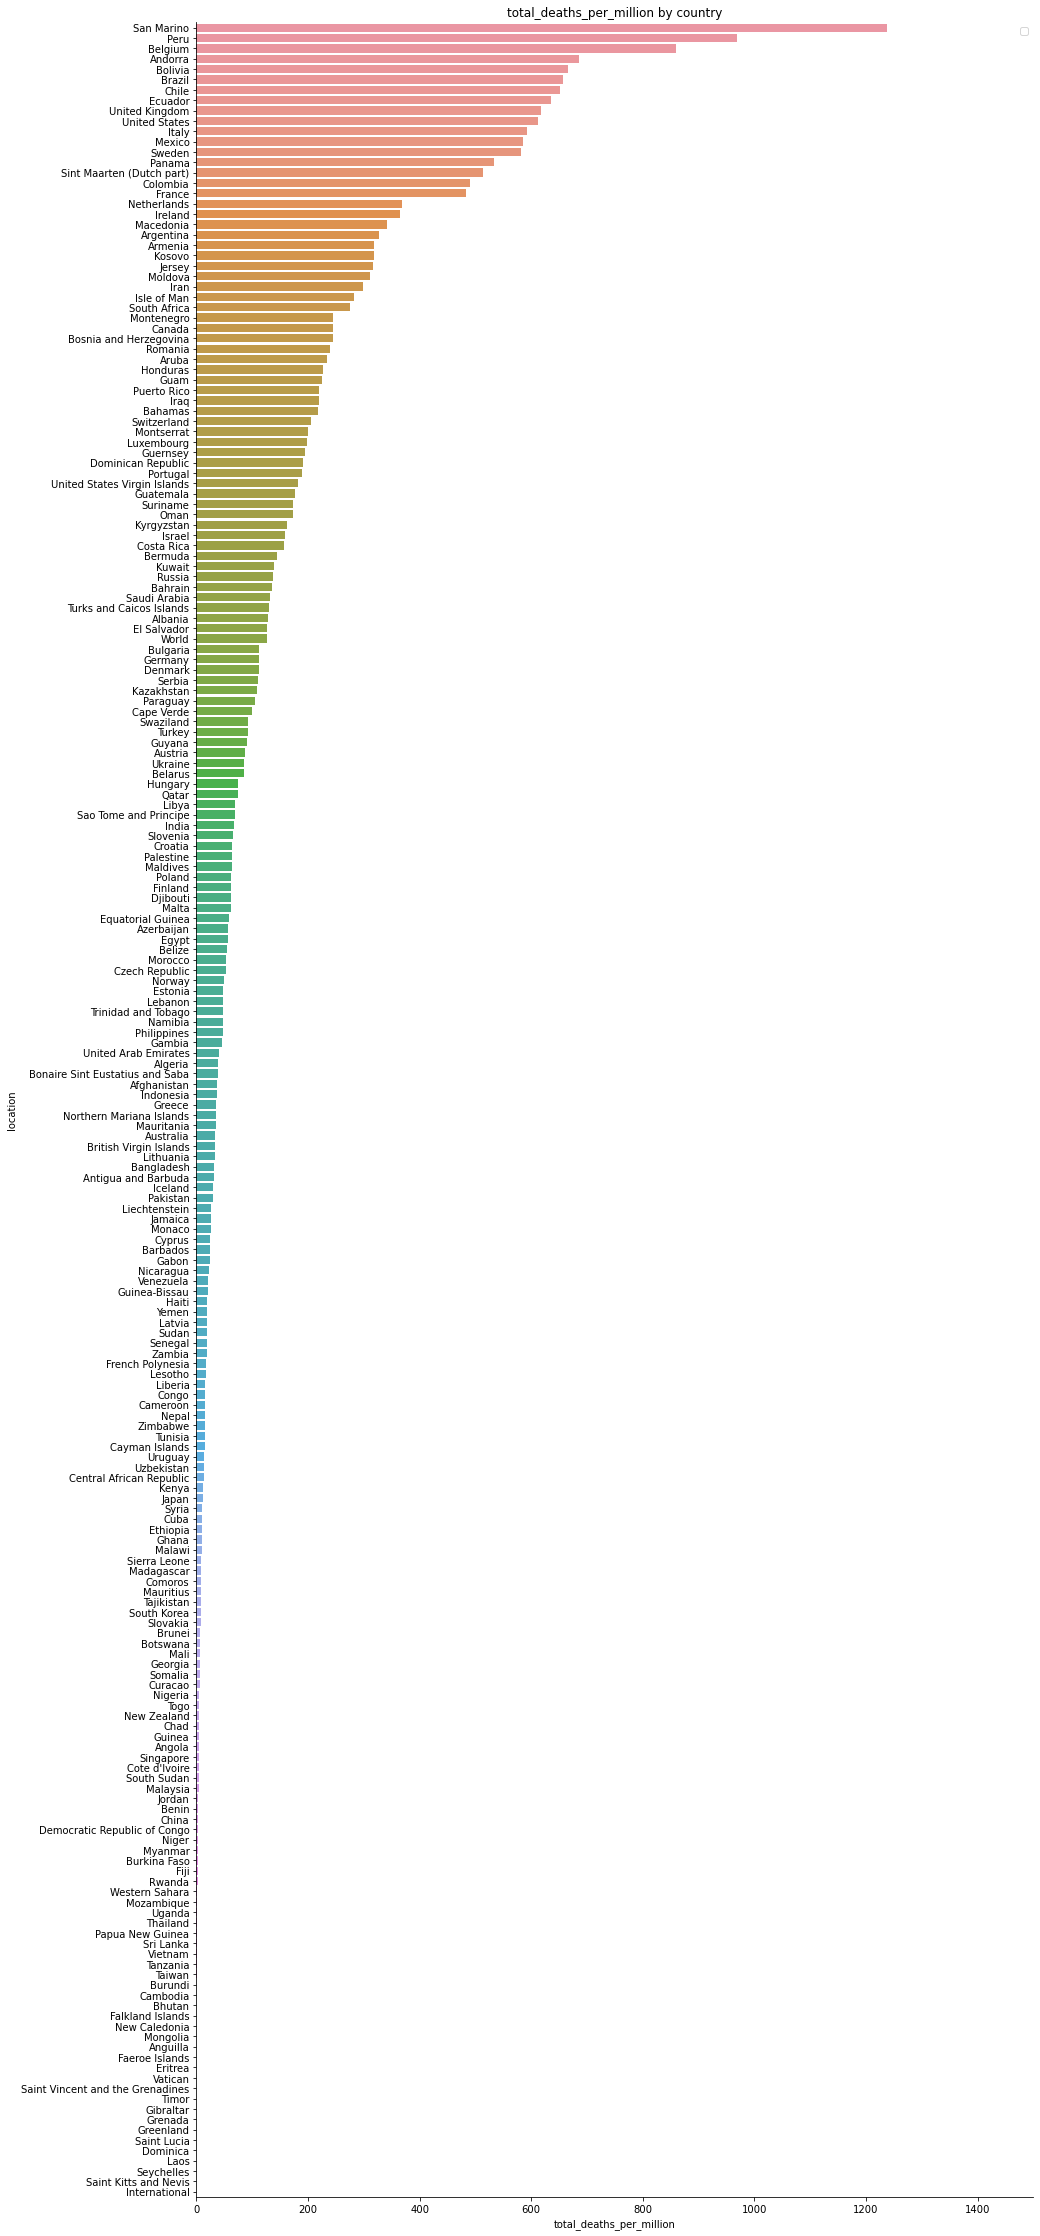

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

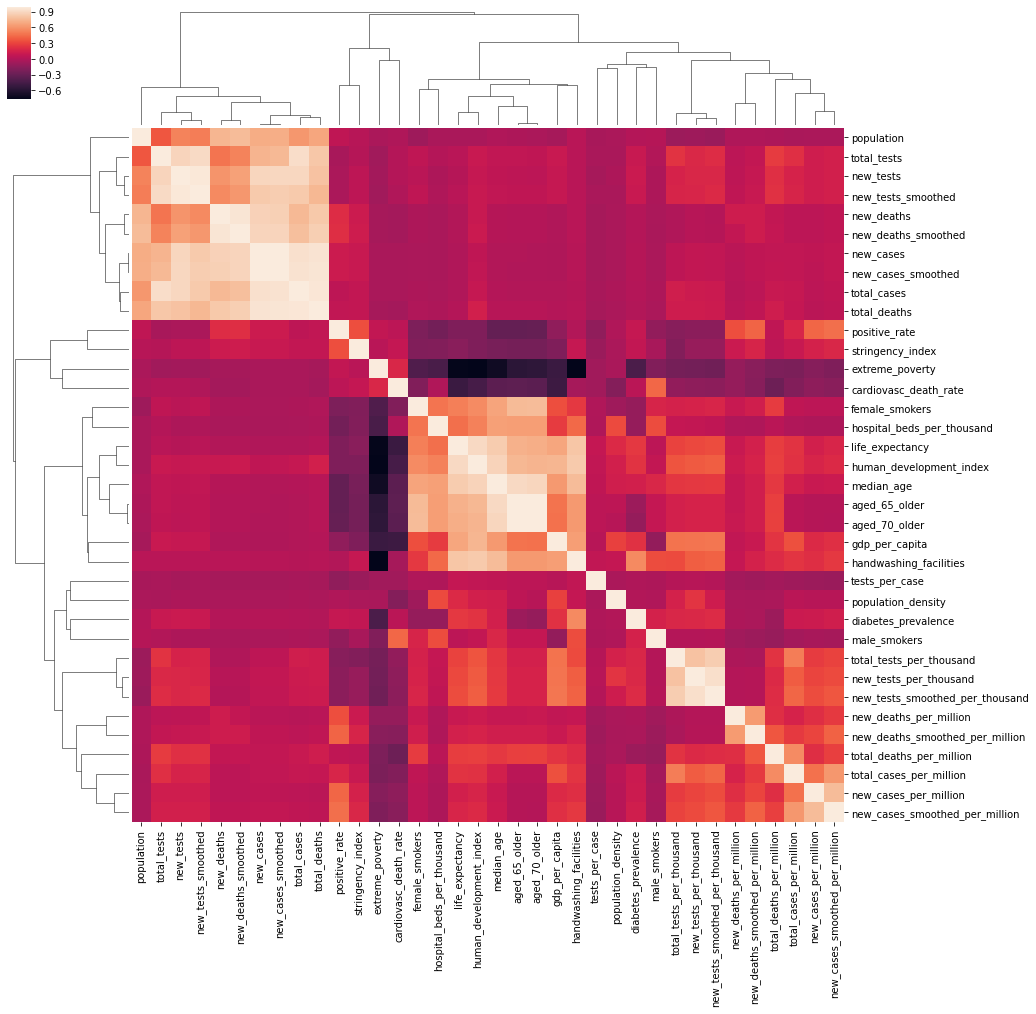

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984791606941839 (+/- 0.0019927488912776063)
Coef :  [1.03103938e+00 8.09565857e-05 8.29918049e-05]
3 Last_days :  [[31673238 31982171 32289042]]
Today :  32289042
Prediction + :  478996
Tomorow :  32768038
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996240862099323 (+/- 0.00013615465012946088)
Coef :  [0.23659743 0.37622681 0.39716718]
3 Last_days :  [[972009 978375 984040]]
Today :  984040
Prediction + :  8253
Tomorow :  992293
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.6316821293399358 (+/- 2.3032577319133556)
Coef :  [-0.73213805  0.76055126  0.97796283]
3 Last_days :  [[468069 481141 497237]]
Today :  497237
Prediction + :  12112
Tomorow :  509349
                                     
--------- Total Death -----------------
                                     
R^2: 0.7643929641069088 (+/- 0.3241132611802564)
Coef :  [-0.74535642  0.78757261  0.95674305]
3 Last_days :  [[31416 31459 31511]]
Today :  31511
Prediction + :  51
Tomorow :  31562
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9690330904364765 (+/- 0.030879325506932266)
Coef :  [-0.33054632 -0.00925948  1.33407017]
3 Last_days :  [[90399 90409 90424]]
Today :  90424
Prediction + :  17
Tomorow :  90441
                                     
--------- Total Death -----------------
                                     
R^2: -27.87107820215492 (+/- 40.729438797466)
Coef :  [-0.07769966  0.01249014  1.0568956 ]
3 Last_days :  [[4737 4738 4738]]
Today :  4738
Prediction + :  5
Tomorow :  4743
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9612445354666662 (+/- 0.05362022726428343)
Coef :  [-0.80883941  0.89105758  0.9172596 ]
3 Last_days :  [[300897 302537 304323]]
Today :  304323
Prediction + :  1424
Tomorow :  305747
                                     
--------- Total Death -----------------
                                     
R^2: -0.1378745294468654 (+/- 1.588680950824534)
Coef :  [-0.8187931   0.89484827  0.92293563]
3 Last_days :  [[35738 35758 35781]]
Today :  35781
Prediction + :  34
Tomorow :  35815
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.36438108966424365 (+/- 1.9189033175442247)
Coef :  [-0.24936043  0.14468794  1.11325419]
3 Last_days :  [[682267 693556 704209]]
Today :  704209
Prediction + :  9994
Tomorow :  714203
                                     
--------- Total Death -----------------
                                     
R^2: -0.6635294610117607 (+/- 2.0545083412369713)
Coef :  [-0.72986625  0.64337752  1.0855456 ]
3 Last_days :  [[30904 31034 31118]]
Today :  31118
Prediction + :  111
Tomorow :  31229
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9205368999383473 (+/- 0.10989903466279079)
Coef :  [0.14851453 0.42880642 0.43515129]
3 Last_days :  [[6896274 6934204 6978417]]
Today :  6978417
Prediction + :  74792
Tomorow :  7053209
                                     
--------- Total Death -----------------
                                     
R^2: 0.986193506525575 (+/- 0.01820912795837704)
Coef :  [-0.3809635   0.66118939  0.72256804]
3 Last_days :  [[200807 201909 202810]]
Today :  202810
Prediction + :  1197
Tomorow :  204007
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.944527183411708 (+/- 0.07732904286280808)
Coef :  [-0.68617527  0.82691931  0.86056202]
3 Last_days :  [[403551 409729 416363]]
Today :  416363
Prediction + :  4363
Tomorow :  420726
                                     
--------- Total Death -----------------
                                     
R^2: 0.19822549643415147 (+/- 1.0999663035142433)
Coef :  [-0.76283767  0.82956618  0.93250988]
3 Last_days :  [[41825 41862 41902]]
Today :  41902
Prediction + :  59
Tomorow :  41961
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9669512931183787 (+/- 0.04582141450449555)
Coef :  [-0.77245521  0.84635103  0.92614784]
3 Last_days :  [[275927 278070 280223]]
Today :  280223
Prediction + :  1831
Tomorow :  282054
                                     
--------- Total Death -----------------
                                     
R^2: 0.201622210251612 (+/- 1.1211255907508573)
Coef :  [-0.78229406  0.83848869  0.9430138 ]
3 Last_days :  [[9409 9428 9443]]
Today :  9443
Prediction + :  20
Tomorow :  9463
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.994616717589475 (+/- 0.005926711936477498)
Coef :  [0.36926307 0.3228397  0.31917343]
3 Last_days :  [[429193 432798 436319]]
Today :  436319
Prediction + :  2795
Tomorow :  439114
                                     
--------- Total Death -----------------
                                     
R^2: 0.9165176104102243 (+/- 0.11727090295342926)
Coef :  [0.17948816 0.4219815  0.40976759]
3 Last_days :  [[24656 24840 25015]]
Today :  25015
Prediction + :  215
Tomorow :  25230
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995362012226993 (+/- 0.00038258839482134565)
Coef :  [-0.61288367  0.79175334  0.81857095]
3 Last_days :  [[306302 308069 309790]]
Today :  309790
Prediction + :  1340
Tomorow :  311130
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990886595354397 (+/- 0.0008644667220831501)
Coef :  [-0.81760175  0.89627871  0.91976835]
3 Last_days :  [[7639 7711 7785]]
Today :  7785
Prediction + :  58
Tomorow :  7843
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9589627538825448 (+/- 0.05432024754744152)
Coef :  [-0.1228685   0.51398696  0.62065532]
3 Last_days :  [[4591604 4624885 4657702]]
Today :  4657702
Prediction + :  54896
Tomorow :  4712598
                                     
--------- Total Death -----------------
                                     
R^2: 0.4509286008320745 (+/- 0.7693646679804785)
Coef :  [-0.02536238  0.48517728  0.55023837]
3 Last_days :  [[138108 138977 139808]]
Today :  139808
Prediction + :  1394
Tomorow :  141202
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(32289042, 984040, 32768038, 992293),
 (497237, 31511, 509349, 31562),
 (304323, 35781, 305747, 35815),
 (704209, 31118, 714203, 31229),
 (6978417, 202810, 7053209, 204007),
 (90424, 4738, 90441, 4743),
 (416363, 41902, 420726, 41961),
 (280223, 9443, 282054, 9463),
 (436319, 25015, 439114, 25230),
 (309790, 7785, 311130, 7843),
 (4657702, 139808, 4712598, 141202)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-25,France,509349.0,0.0,31562.0,0.0,0.0,0.0
0,2020-09-25,China,90441.0,0.0,4743.0,0.0,0.0,0.0
0,2020-09-25,Italy,305747.0,0.0,35815.0,0.0,0.0,0.0
0,2020-09-25,Spain,714203.0,0.0,31229.0,0.0,0.0,0.0
0,2020-09-25,United States,7053209.0,0.0,204007.0,0.0,0.0,0.0
0,2020-09-25,World,32768038.0,0.0,992293.0,0.0,0.0,0.0
0,2020-09-25,United Kingdom,420726.0,0.0,41961.0,0.0,0.0,0.0
0,2020-09-25,Germany,282054.0,0.0,9463.0,0.0,0.0,0.0
0,2020-09-25,Iran,439114.0,0.0,25230.0,0.0,0.0,0.0
0,2020-09-25,Turkey,311130.0,0.0,7843.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")